In [ ]:
from shared.preface import *
import shared.functions as fct

## Grid building tests.

### 2D grid, center coord. pairs.

In [ ]:
from shared.preface import *
import shared.functions as fct

def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

### 3D grid, center coord. pairs.

In [ ]:
from shared.preface import *
import shared.functions as fct

# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

In [ ]:
from shared.preface import *
import shared.functions as fct

grid = fct.grid_3D(200,100)


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

xg, yg, zg = grid[:,0], grid[:,1], grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)
ax.view_init(-170,90)

## Analyze gravity.

In [1]:
from shared.preface import *
import shared.functions as fct

### -------------------------------- ###
### Initialize parameters and files. ###
### -------------------------------- ###

# Parameters.
sim_id = 'L006N188'
snap_num = '0036'
z = 0

# Generate progenitor index list.
# note on init_halo for L006N188 sim: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun.
m0, prog_idx = fct.read_MergerTree(init_halo=0) 
halo_0036 = prog_idx[0][0]

# Generate file for DM particles of chosen halo and get parameters.
halo_cNFW, halo_rvir, halo_Mvir = fct.read_DM_positions_alt2(
    which_halos='halos', mass_select=12,  # outdated but necessary...
    random=False, snap_num=snap_num, sim=sim_id, 
    halo_index=int(halo_0036), init_m=m0, save_params=True
)
halo_rvir *= kpc
halo_Mvir = 10**halo_Mvir * Msun
halo_rho0 = fct.scale_density_NFW(z, halo_cNFW)
halo_Rs = halo_rvir / halo_cNFW
print(
    f'Halo parameters: (m0={m0})',
    '\n', 
    f'halo_index={halo_0036} ; cNFW={halo_cNFW:.2f}',
    f'rvir={halo_rvir/kpc:.2f} kpc ; Mvir={halo_Mvir/Msun:.2e} Msun'
)

DM_raw = np.load(
    f'CubeSpace/DM_positions_{sim_id}_snapshot_{snap_num}_{m0}Msun.npy'
)*kpc
DM_pos = np.expand_dims(DM_raw, axis=0)

DM_lim_custom = 1000

# Custom initial grid.
GRID_L_custom = 400*kpc
GRID_S_custom = 400*kpc

DM_rad_None = 'None'  #! acutally in read_DM_position_alt2 it's fixed to 500 kpc

fin_grid, cell_gen, cell_com, DM_count = fct.manual_cell_division(
    sim_id, snap_num, DM_raw,
    DM_lim_custom, GRID_L_custom, GRID_S_custom, m0, DM_rad_None,
)

### ------------------------------- ###
### Calculate gravity of cell grid. ###
### ------------------------------- ###
# Generate gravity grid, in batches of cells, due to memory intensity.
batch_size = 50
bs_cc = chunks(batch_size, fin_grid)
bs_gen = chunks(batch_size, cell_gen)
bs_com = chunks(batch_size, cell_com)
bs_count = chunks(batch_size, DM_count)

long_yesno = True

b_nums = []
for b,  (b_cc,  b_gen,  b_com,  b_count) in enumerate(
    zip(bs_cc, bs_gen, bs_com, bs_count)
):
    b_nums.append(b)
    b_cc = np.array(b_cc)
    b_gen = np.array(b_gen)
    b_com = np.array(b_com)
    b_count = np.array(b_count)

    # Calculate gravity in each cell in current batch.
    b_DM = np.repeat(DM_pos, len(b_cc), axis=0)
    fct.cell_gravity_3D(
        b_cc, b_com, b_gen,
        b_DM, b_count, DM_SIM_MASS, snap_num, m0,
        long_range=long_yesno, test_names=True,
        batches=True, batch_num=b
    )
bs_nums = np.array(b_nums)

# Combine and then delete batch files.
dPsi_batches = [
    np.load(
        f'CubeSpace/dPsi_grid_snapshot_TestFile_batch{b}.npy'
    ) for b in bs_nums
]
dPsi_combined = np.array(
    list(chain.from_iterable(dPsi_batches))
)
np.save(f'CubeSpace/dPsi_grid_snapshot_TestFile_{m0}Msun.npy', dPsi_combined)
fct.delete_temp_data('CubeSpace/dPsi_*batch*.npy') 

dPsi_grid = np.load(f'CubeSpace/dPsi_grid_snapshot_TestFile_{m0}Msun.npy')
cube_mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))


### ------------------------------------------- ###
### Calculate NFW gravity with halo parameters. ###
### ------------------------------------------- ###
adapted_grid = np.squeeze(fin_grid, axis=1)
NFW_grav = np.array([
    fct.dPsi_dxi_NFW(x_i, z, halo_rho0, halo_Mvir, halo_rvir, halo_Rs, 'HALO')
    for x_i in adapted_grid
])
NFW_mags = np.sqrt(np.sum(NFW_grav**2, axis=1))

# Sort cells by distance from center (0,0,0).
grid_dis = np.sqrt(np.sum(adapted_grid**2, axis=1))
dis_ind = grid_dis.argsort()

grid_dis = grid_dis[dis_ind]
cube_mags = cube_mags[dis_ind]
NFW_mags = NFW_mags[dis_ind]

Halo parameters: (m0=1.89e+12) 
 halo_index=0 ; cNFW=8.61 rvir=260.50 kpc ; Mvir=1.89e+12 Msun
Grid and DM shapes before division: (8, 1, 3) (8, 1312481, 3)
cell division rounds: 6
Shapes of output files: (995, 1, 3) (995,) (995, 3) (995,)
Total DM count across all cells: 1312480
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good

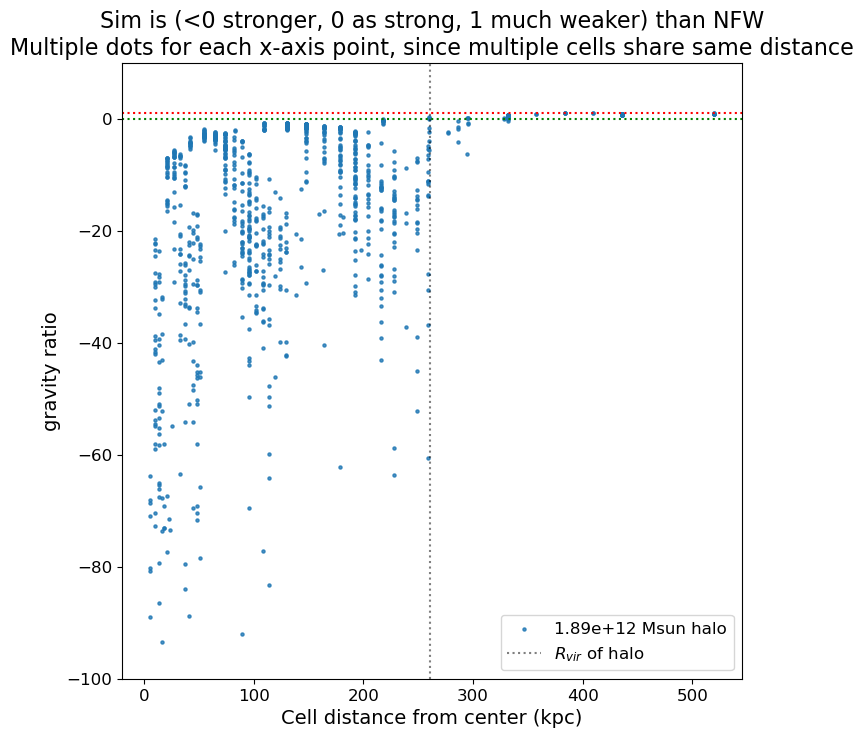

In [2]:
fig, ax = plt.subplots(1,1)

diff = (NFW_mags-cube_mags)/NFW_mags

ax.scatter(
    grid_dis/kpc, diff, s=5, alpha=0.8, label=f'{m0} Msun halo'
)
ax.axhline(1, c='red', ls=':')
ax.axhline(0, c='green', ls=':')
ax.axvline(halo_rvir/kpc, c='black', ls=':', alpha=0.5, label=r'$R_{vir}$ of halo')


# def y_fmt_here(value, tick_number):
#     return np.round(1-value,1)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt_here))

thumb_rule ='(<0 stronger, 0 as strong, 1 much weaker)'
ax.set_title(
    f'Sim is {thumb_rule} than NFW'
    '\n'
    'Multiple dots for each x-axis point, since multiple cells share same distance'
    )
ax.set_xlabel(f'Cell distance from center (kpc)')
ax.set_ylabel(f'gravity ratio')
ax.set_ylim(-100,10)
plt.legend(loc='lower right')
plt.savefig('figures/sim_vs_NFW_gravity.pdf')
plt.show()

## Visualize LSS: (sub)halos and cell division.

In [ ]:
from shared.preface import *
import shared.functions as fct

# %matplotlib widget

# Parameters.
sim_id = 'L006N188'
snap_num = '0036'
z = 0
halo_type = 'halos'
mass_gauge = 11


if halo_type == 'halos':
    # Generate progenitor index list.
    # note on init_halo for L006N188 sim: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun.
    init_halo = 0
    m0, prog_idx = fct.read_MergerTree(init_halo) 

    # Generate file for DM particles of chosen halo and get parameters.
    halo_cNFW, halo_rvir, halo_Mvir = fct.read_DM_positions(
        random=False, snap_num=snap_num, sim=sim_id, 
        halo_index=int(init_halo), init_m=m0, save_params=True
    )
    halo_rvir *= kpc
    halo_Mvir = 10**halo_Mvir * Msun

    DM_raw = np.load(
        f'CubeSpace/DM_positions_{sim_id}_snapshot_{snap_num}_{m0}Msun.npy'
    )*kpc

elif halo_type == 'subhalos':
    # Generate file for DM particles of chosen halo and get parameters.
    halo_cNFW, halo_rvir, halo_Mvir = fct.read_DM_positions(
        which_halos=halo_type, mass_select=mass_gauge, mass_range=1,
        random=True, snap_num=snap_num, sim=sim_id, 
        save_params=True
    )
    halo_rvir *= kpc
    halo_Mvir = 10**halo_Mvir * Msun

    DM_raw = np.load(
        f'CubeSpace/DM_positions_{halo_type}_M{mass_gauge}.npy'
    )*kpc

print(
    f'Halo parameters:',
    '\n', 
    f'cNFW={halo_cNFW:.2f}',
    f'rvir={halo_rvir/kpc:.2f} kpc ; Mvir={halo_Mvir/Msun:.2e} {m0} Msun'
)

# DM_lim_custom = 100000000
# GRID_L_custom = 600*kpc
# GRID_S_custom = 600*kpc

# fin_grid, cell_gen, cell_com, DM_count = fct.manual_cell_division(
#     sim_id, snap_num, DM_raw, DM_lim_custom, 
#     GRID_L_custom, GRID_S_custom, m0
# )


################################################
### Plotting the outcome after iteration(s). ###
################################################

# Build grid around Milky Way.
# trimmed_cc = np.delete(fin_grid, np.s_[DM_count==0], axis=0)
# print(trimmed_cc.shape)
# new_grid = np.squeeze(fin_grid, axis=1) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot DM.
DM_raw /= kpc
x_DM, y_DM, z_DM = DM_raw[:,0], DM_raw[:,1], DM_raw[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=0.9, c='rebeccapurple', s=0.001)

# Draw sphere around GC with radius=Rvir_MW.
rGC = halo_rvir/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

# Plot Grid.
# xg, yg, zg = new_grid[:,0], new_grid[:,1], new_grid[:,2] 
# ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)

# Can't make it show up with all the DM particles.
# ax.scatter(
#     X_SUN[0], X_SUN[1], X_SUN[2], s=10, color='blue', marker='o',
#     label='Earth', zorder=0
# )

ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# ax.view_init(-170,90)

# zero_cells = np.count_nonzero(DM_count==0.)
# print(f'Cells without DM: {zero_cells} / {len(new_grid)}')

plt.savefig('figures/cell_division_visual.pdf')
plt.show()

2089250
1928478
2171393
3769327


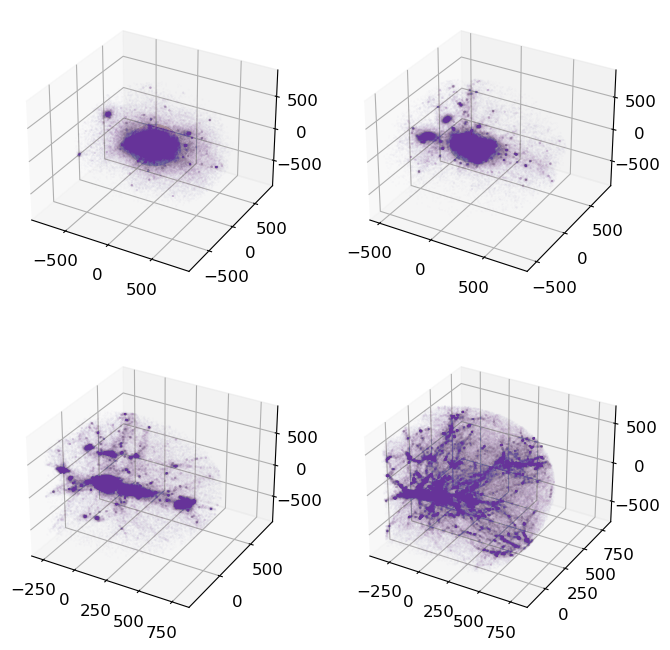

In [6]:
from shared.preface import *
import shared.functions as fct

# Parameters.
sim_id = 'L006N188'
snap_num = '0036'

fig = plt.figure(figsize=(8,8))

for j, snap_num in enumerate(NUMS_SNAPSHOTS[::-1][[0,10,-8,-1]]):

    # Generate progenitor index list.
    # note on init_halo for L006N188 sim: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun.
    init_halo = 0
    m0, prog_idx = fct.read_MergerTree(init_halo) 

    # Radius of inclusion for DM structure/particles (in kpc).
    DM_radius = 800

    # Generate file for DM particles of chosen halo and get parameters.
    halo_rvir = fct.read_DM_positions(
        snap_num, sim_id, 
        int(init_halo), m0, DM_radius
    )
    halo_rvir *= kpc

    DM_raw = np.load(
        f'CubeSpace/DM_positions_{sim_id}_snapshot_{snap_num}_{m0}Msun_{DM_radius}kpc.npy'
    )*kpc
    print(len(DM_raw))

    ax_num = 221 + j
    ax = fig.add_subplot(ax_num, projection='3d')

    # Plot DM.
    DM_raw /= kpc
    x_DM, y_DM, z_DM = DM_raw[:,0], DM_raw[:,1], DM_raw[:,2]
    cut = 10
    x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
    ax.scatter(x, y, z, alpha=0.5, c='rebeccapurple', s=0.0001)

    # Draw sphere around GC with radius=Rvir_MW.
    rGC = halo_rvir/kpc
    uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
    xGC = rGC * np.cos(uGC) * np.sin(vGC)
    yGC = rGC * np.sin(uGC) * np.sin(vGC)
    zGC = rGC * np.cos(vGC)

    ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
    )

plt.show()

## Visualize halo mass evolution through snapshots.

In [ ]:
sim_ID = 'L006N188'

# Path to merger_tree file (has to have been generated with merger_tree.py)
tree_path = f'{pathlib.Path.cwd().parent}/neutrino_clustering_output_local/MergerTree/MergerTree_{sim_ID}.hdf5'

with h5py.File(tree_path) as tree:
    choice = 1  #note: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun
    Masses = tree['Assembly_history/Mass'][:10,:]
    zeds = tree['Assembly_history/Redshift']
    
    masses = np.asarray(Masses)
    z = np.asarray(zeds)

    fig = plt.figure()

    for m in masses:
        plt.semilogy(z, m, label=f'{m[0]:.2e}')

    plt.title(u'Starting mass in labels ->')
    plt.xlabel('redshift')
    plt.ylabel('halo masses [Msun]')
    plt.legend()
    plt.show()

## Neutrino velocity batches.

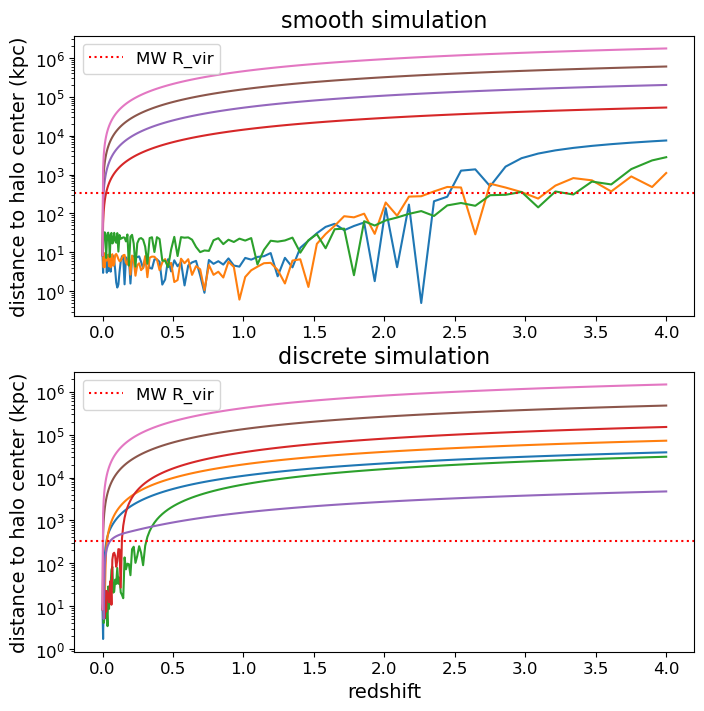

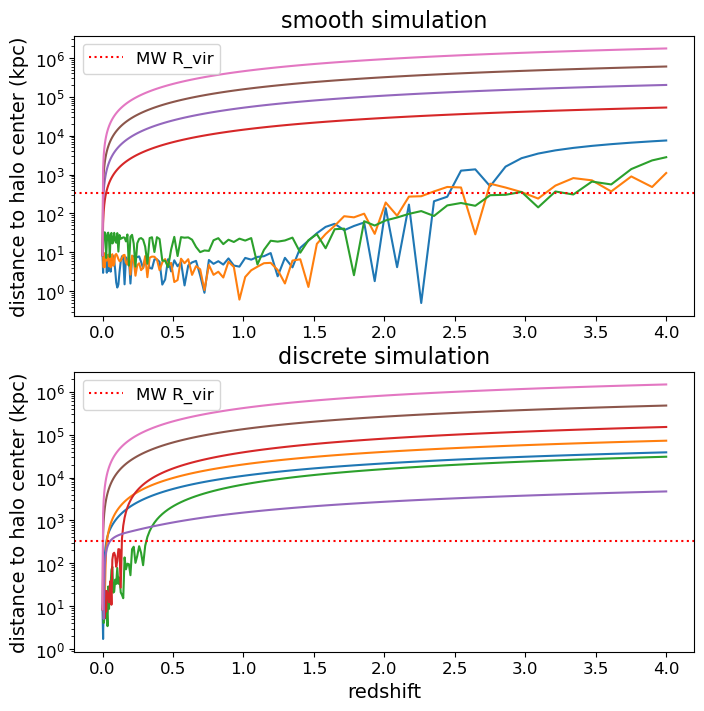

In [9]:
from shared.preface import *
import shared.functions as fct

nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO

DM_radii = np.linspace(260, 800, 5)

for DM_radius in DM_radii[[0,-2]]:

    fig, ax = plt.subplots(2,1)
    for j, method in enumerate(('smooth', 'discrete')):

        if method == 'smooth':
            Cubes = False
        else:
            Cubes = True

        # Load positions and velocities.
        vel = fct.load_u_sim(
            nus, halos=halos, discrete=Cubes, DM_radius=DM_radius
        )
        pos = fct.load_x_sim(
            nus, halos=halos, discrete=Cubes, DM_radius=DM_radius
        )

        # Magnitudes of velocities and radial distances from halo center.
        mag = np.sqrt(np.sum(vel**2, axis=2))
        dis = np.sqrt(np.sum(pos**2, axis=2))

        # Sort arrays from low to high velocity neutrinos.
        ids = mag[:,0].argsort()
        ids_2D = np.repeat(np.expand_dims(ids, axis=1), mag.shape[1], axis=1)
        u_unit = (kpc/s)/(km/s)
        mag_sort = np.take_along_axis(mag, ids_2D, axis=0)*u_unit
        dis_sort = np.take_along_axis(dis, ids_2D, axis=0)

        # Special velocity markers.
        v_start = mag_sort[:,0]
        v_max = v_start.max()
        v_esc = mag_sort[np.where(v_start <= 550)]

        # Velocity batches.
        v1 = mag_sort[np.where(v_start <= v_max/4)]
        v2 = mag_sort[
            np.where((v_max/4 < v_start) & (v_start <= v_max/2))
        ]
        v3 = mag_sort[
            np.where((v_max/2 < v_start) & (v_start <= v_max*3/4))
        ]
        v4 = mag_sort[np.where(v_max*3/4 < v_start)]

        # Corresponding distance batches.
        d1 = dis_sort[:len(v1),:]
        d2 = dis_sort[len(v1):len(v1)+len(v2),:]
        d3 = dis_sort[len(v1)+len(v2):len(v1)+len(v2)+len(v3),:]
        d4 = dis_sort[len(v1)+len(v2)+len(v3):,:]
        # d_esc = dis_sort[:v_esc.shape[0],:]

        # Print some stats.
        print_yesno = False
        if print_yesno:
            print('vel patches:', v1.shape, v2.shape, v3.shape, v4.shape)
            print(
                'Velocity edges for each batch: \n', 
                f'Batch 1: {v1[0,0]} to {v1[-1,0]} check: {v_max/4} \n',
                f'Batch 2: {v2[0,0]} to {v2[-1,0]} check: {v_max/2} \n',
                f'Batch 3: {v3[0,0]} to {v3[-1,0]} check: {v_max*3/4} \n',
                f'Batch 3: {v4[0,0]} to {v4[-1,0]} check: {v_max}',
            )
            print('dis patches:', d1.shape, d2.shape, d3.shape, d4.shape)

        batches = False

        if batches == True:
            for i, d in enumerate((d1,d2,d3,d4)):
                print(d.shape, d[0,0], d[0,-1])
                y_vals = np.mean(d, axis=0)
                ax[j].semilogy(ZEDS, y_vals, alpha=0.7, label=f'batch {i} mean')
        else:
            # d_low = dis_sort[:3000,:][::300]   #! lowest velocities
            d_low = dis_sort[3000:,:][::1000]  #! highest velocities
            for d in d_low:
                ax[j].semilogy(ZEDS, d)

        ax[j].axhline(Rvir_MW/kpc, c='r', ls=':', label='MW R_vir')
        # ax[j].set_xlim(-0.01,1)
        ax[j].legend()
        ax[j].set_title(f'{method} simulation')
        ax[j].set_ylabel('distance to halo center (kpc)')

        if j == 1:
            ax[j].set_xlabel('redshift')

    plt.savefig(f'figures/velocity_batches_DM_radius_{DM_radius}kpc.pdf')
    plt.show()

## Center of mass of used DM structure.

In [ ]:
from shared.preface import *
import shared.functions as fct

def com_coord_snap(snap_num, sim, halo_index=0):

    # Open data files.
    snaps = h5py.File(str(next(
        pathlib.Path(
            f'{SIM_DATA}/{sim}').glob(f'**/snapshot_{snap_num}.hdf5'
        )
    )))
    props = h5py.File(str(next(
        pathlib.Path(
            f'{SIM_DATA}/{sim}').glob(f'**/subhalo_{snap_num}.properties'
        )
    )))

    ### Properties of DM particles.

    # Positions.
    a = snaps["/Header"].attrs["Scale-factor"]
    pos = snaps['PartType1/Coordinates'][:][:] * a

    # Virial radius.
    rvir = props['R_200crit'][:]
    
    # Critical M_200.
    m200c = props['Mass_200crit'][:] * 1e10  # now in Msun

    # Set neg. values to 1, i.e. 0 in np.log10.
    m200c[m200c <= 0] = 1

    # This gives exponents of 10^x, which reproduces m200c vals.
    m200c = np.log10(m200c)  

    # Center of Potential coordinates, for all halos.
    CoP = np.zeros((len(m200c), 3))
    CoP[:, 0] = props["Xcminpot"][:]
    CoP[:, 1] = props["Ycminpot"][:]
    CoP[:, 2] = props["Zcminpot"][:]

    # Include all DM particles within certain radius.
    halo_rvir = rvir[halo_index]
    pos -= CoP[halo_index, :]
    dis = np.sqrt(np.sum(pos**2, axis=1))
    particles_pos = pos[dis <= halo_rvir*2]
    particles_pos *= 1e3
    
    DM_particles = len(particles_pos)
    com_coord = np.sum(particles_pos, axis=0) / DM_particles

    return com_coord

# Parameters.
sim_id = 'L006N188'
snap_num = '0036'
z = 0

# Generate progenitor index list.
# note on init_halo for L006N188 sim: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun.
init_halo = 0
m0, prog_idx = fct.read_MergerTree(init_halo) 

# Generate file for DM particles of chosen halo and get parameters.
com_coord = com_coord_snap(snap_num, sim_id, int(init_halo))

print(f'Center of mass coordinates, of a ~1e12Msun halo is:\n {com_coord/kpc}')
print('Since very close to (0,0,0), outside_gravity does not have to change.')